In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df=pd.read_csv('/content/drive/MyDrive/final_dataset.csv')

In [3]:
# Display basic information about the dataset
print("Dataset Head:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nClass Distribution:")
print(df['label'].value_counts())


Dataset Head:
                                               tweet          label  \
0  believe cry depression exhaustion fatigue get ...           mild   
1  another cry depression night pain raw time unh...           mild   
2  awake bad bed checkmate depression do drag ear...           mild   
3  cruel depression empathy hear lack maybe never...  non-depressed   
4  allow always anxiety blue cure day depression ...  non-depressed   

   confidence_score  
0             0.667  
1             0.674  
2             0.682  
3             1.000  
4             1.000  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134132 entries, 0 to 134131
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tweet             134108 non-null  object 
 1   label             134132 non-null  object 
 2   confidence_score  134132 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.1+ MB
None

Clas

In [4]:
from sklearn.utils import shuffle


# Shuffle the dataframe
df_shuffled = shuffle(df, random_state=42)

# Reset index after shuffling
df_shuffled = df_shuffled.reset_index(drop=True)

# Print the shuffled dataframe
print(df_shuffled.head())

                                               tweet          label  \
0  basement chance could depress depression die f...         severe   
1  also anyone back chronic dad deal depress depr...       moderate   
2  back bother break clean control cry day depres...       moderate   
3  badly drain emotionally good hold mentally nee...  non-depressed   
4  already away could dangerous depress depressio...       moderate   

   confidence_score  
0          0.768395  
1          0.770545  
2          0.799537  
3          0.682000  
4          0.851828  


In [5]:
# Assuming df is your DataFrame
df_shuffled.dropna(subset=['tweet'], inplace=True)
print("\nDataset Info:")
print(df_shuffled.info())

# Ensure all tweets are strings
df_shuffled['tweet'] = df_shuffled['tweet'].astype(str)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 134108 entries, 0 to 134131
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tweet             134108 non-null  object 
 1   label             134108 non-null  object 
 2   confidence_score  134108 non-null  float64
dtypes: float64(1), object(2)
memory usage: 4.1+ MB
None


In [6]:
dcl=df_shuffled["label"].value_counts().reset_index()
dcl.columns=["Label","Count"]
dcl

,Label,Count
0,severe,33533
1,moderate,33533
2,mild,33533
3,non-depressed,33509


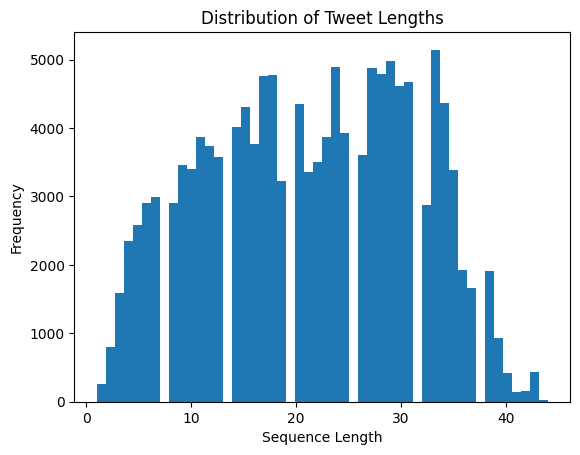

Number of unique tokens: 12691


In [7]:
# Tokenize the tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_shuffled['tweet'])
sequences = tokenizer.texts_to_sequences(df_shuffled['tweet'])

# Get the length of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Plot the distribution of sequence lengths
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.show()

# Print the number of unique tokens
num_unique_tokens = len(tokenizer.word_index)
print(f'Number of unique tokens: {num_unique_tokens}')

In [8]:
# Extract the features and target variable
X_texts = df_shuffled['tweet'].values
X_confidences = df_shuffled['confidence_score'].values
y_labels = df_shuffled['label'].values


In [9]:
# Set parameters
num_words = 12691  # Number of unique tokens
max_length = 50

# Apply the tokenizer and scaler
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df_shuffled['tweet'])
X_sequences = tokenizer.texts_to_sequences(X_texts)
X_padded_sequences = pad_sequences(X_sequences, maxlen=50, padding='post', truncating='post')


scaler = StandardScaler()
X_scaled_confidences = scaler.fit_transform(X_confidences.reshape(-1, 1))


In [11]:
# Define your own mapping
label_mapping = {'mild': 0, 'moderate': 1, 'severe': 2, 'non-depressed': 3}

# Map labels to their numerical values
y_encoded_labels = [label_mapping[label] for label in y_labels]


# Initialize and fit LabelEncoder (optional, just for consistency with previous examples)
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y_encoded_labels)

# Print encoded labels and corresponding classes
print("Encoded Labels:", y_encoded_labels)
print("Label Classes:", label_encoder.classes_)

Encoded Labels: [2, 1, 1, 3, 1, 3, 1, 2, 2, 3, 0, 0, 0, 2, 1, 2, 1, 0, 3, 1, 3, 2, 3, 3, 0, 2, 2, 0, 3, 3, 2, 0, 3, 0, 1, 2, 1, 3, 2, 0, 0, 0, 0, 2, 0, 2, 3, 2, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 0, 0, 2, 2, 0, 2, 2, 0, 3, 0, 1, 2, 1, 2, 0, 0, 1, 2, 2, 3, 2, 2, 3, 1, 3, 1, 0, 3, 0, 1, 0, 0, 0, 2, 1, 2, 1, 0, 3, 0, 3, 2, 0, 1, 2, 2, 1, 3, 1, 1, 3, 0, 0, 0, 1, 0, 3, 1, 0, 2, 2, 3, 2, 0, 2, 3, 1, 0, 0, 0, 1, 0, 2, 2, 1, 2, 0, 1, 2, 3, 1, 0, 3, 3, 2, 0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 3, 1, 3, 2, 2, 1, 3, 0, 1, 3, 3, 3, 0, 2, 0, 1, 0, 0, 3, 3, 0, 1, 3, 0, 1, 3, 3, 3, 2, 2, 2, 1, 3, 1, 2, 2, 1, 0, 0, 2, 1, 3, 3, 1, 1, 3, 0, 2, 3, 2, 0, 2, 1, 3, 0, 0, 2, 1, 0, 3, 1, 3, 1, 2, 1, 2, 2, 0, 0, 0, 1, 3, 3, 3, 2, 2, 3, 3, 3, 1, 0, 2, 3, 3, 2, 3, 1, 0, 3, 2, 3, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 3, 2, 1, 0, 0, 2, 2, 2, 1, 3, 0, 3, 1, 2, 2, 0, 2, 3, 0, 3, 1, 3, 0, 3, 2, 1, 2, 1, 0, 2, 3, 2, 0, 3, 0, 3, 3, 3, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 3, 2, 1, 1, 3, 0, 3, 2, 1, 0, 3, 1, 0, 3, 1, 0, 0, 2, 3, 1, 3,

In [12]:
# Check types and shapes of inputs
print(type(X_padded_sequences), X_padded_sequences.shape)
print(type(X_scaled_confidences), X_scaled_confidences.shape)
y_encoded_labels = np.array(y_encoded_labels)
print(type(y_encoded_labels), y_encoded_labels.shape)

<class 'numpy.ndarray'> (134108, 50)
<class 'numpy.ndarray'> (134108, 1)
<class 'numpy.ndarray'> (134108,)


In [31]:
import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define a function to create and train your model
def train_model(X_padded_sequences, X_scaled_confidences, y_encoded_labels):
    # Define your model

    # Define the model architecture with added regularization
    input_text = Input(shape=(max_length,), name='text_input')
    input_confidence = Input(shape=(1,), name='confidence_input')

    #input_text = tf.keras.Input(shape=(50,), name='text_input') prevous woek correctly
    #input_confidence = tf.keras.Input(shape=(1,), name='confidence_input')

    # Define your model layers here...

    embedding = Embedding(input_dim=num_words + 1, output_dim=64)(input_text)
    lstm = LSTM(64, return_sequences=True)(embedding)
    dropout = Dropout(0.5)(lstm)
    lstm2 = LSTM(32)(dropout)

    merged = concatenate([lstm2, input_confidence])
    dense = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(merged)  # L2 regularization
    output = Dense(4, activation='softmax')(dense)

    # Compile the model
    model = Model(inputs=[input_text, input_confidence], outputs=output)
    #model = tf.keras.Model(inputs=[input_text, input_confidence], outputs=output) # pervois work correctly
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    # Define EarlyStopping Callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model without using @tf.function decorator
    history = model.fit(
        [X_padded_sequences, X_scaled_confidences], y_encoded_labels,
        validation_split=0.2,
        epochs=5,
        batch_size=64,
        callbacks=[early_stopping]
    )
    return model, history

model, history = train_model(X_padded_sequences, X_scaled_confidences, y_encoded_labels)



Epoch 1/5
1677/1677 [==============================] - 244s 108ms/step - loss: 0.2014 - accuracy: 0.9540 - val_loss: 0.0328 - val_accuracy: 0.9969
Epoch 2/5
1677/1677 [==============================] - 180s 108ms/step - loss: 0.0265 - accuracy: 0.9969 - val_loss: 0.0192 - val_accuracy: 0.9975
Epoch 3/5
1677/1677 [==============================] - 180s 107ms/step - loss: 0.0164 - accuracy: 0.9979 - val_loss: 0.0133 - val_accuracy: 0.9985
Epoch 4/5
1677/1677 [==============================] - 181s 108ms/step - loss: 0.0144 - accuracy: 0.9979 - val_loss: 0.0180 - val_accuracy: 0.9969
Epoch 5/5
1677/1677 [==============================] - 169s 101ms/step - loss: 0.0115 - accuracy: 0.9984 - val_loss: 0.0117 - val_accuracy: 0.9985


In [43]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 50)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 50, 64)               812288    ['text_input[0][0]']          
                                                                                                  
 lstm_8 (LSTM)               (None, 50, 64)               33024     ['embedding_4[0][0]']         
                                                                                                  
 dropout_4 (Dropout)         (None, 50, 64)               0         ['lstm_8[0][0]']              
                                                                                            

In [44]:
# Predictions
y_pred = model.predict([X_padded_sequences, X_scaled_confidences])
y_pred_labels = np.argmax(y_pred, axis=1)
y_true= y_encoded_labels
print('y_true.shape()=, :', y_true.shape)
print('y_pred_labels.shape()=, :', y_pred_labels.shape)

4191/4191 [==============================] - 82s 20ms/step
y_true.shape()=, : (134108,)
y_pred_labels.shape()=, : (134108,)


In [45]:
# Metrics

report = classification_report(y_true, y_pred_labels)
print(f"Classification Report:\n {report}")

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     33533
           1       1.00      1.00      1.00     33533
           2       1.00      1.00      1.00     33533
           3       1.00      1.00      1.00     33509

    accuracy                           1.00    134108
   macro avg       1.00      1.00      1.00    134108
weighted avg       1.00      1.00      1.00    134108



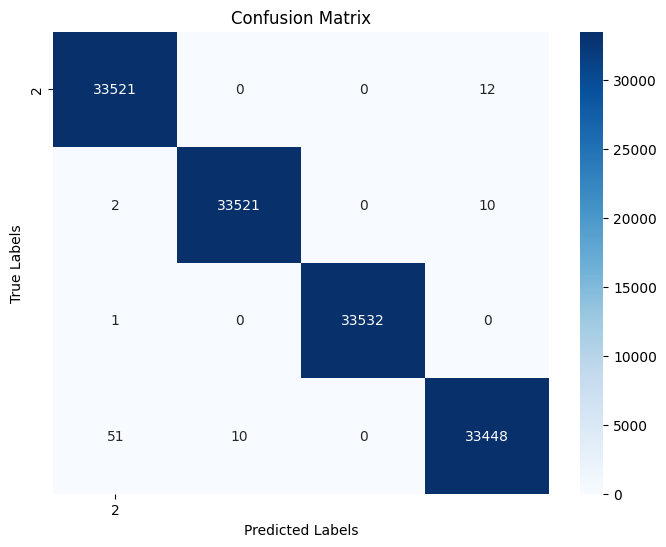

In [55]:

# Plot confusion matrix

conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

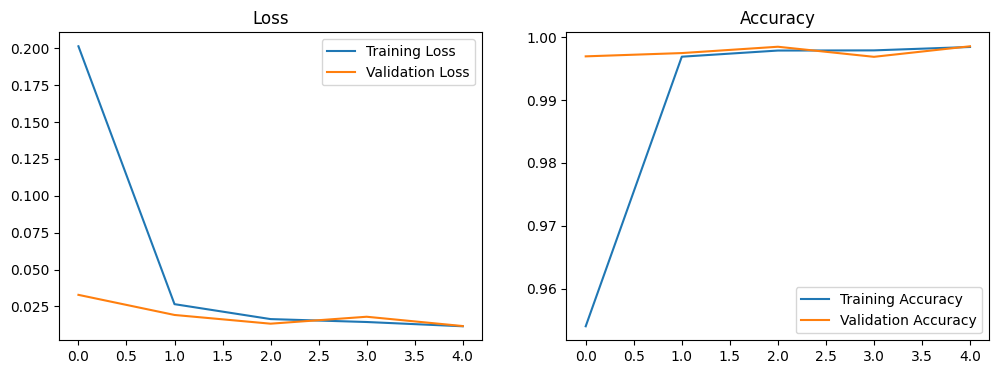

In [32]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()
plot_training_history(history)



In [57]:
# Save the model and resources
model.save('/content/drive/MyDrive/fyp_model.h5')

with open('/content/drive/MyDrive/fyp_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/fyp_label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/fyp_scaler.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
from tensorflow.keras.models import Model, load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/fyp_model.h5')
# Convert the Keras model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/fyp_model.tflite', 'wb') as f:
    f.write(tflite_model)


print("Model training and saving complete with adjusted parameters.")

Model training and saving complete with adjusted parameters.


In [39]:
def predict_sentiment(tweet, confidence_score):
    # Preprocess the tweet
    sequence = tokenizer.texts_to_sequences([tweet])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Scale the confidence score
    scaled_confidence_score = scaler.transform(np.array([confidence_score]).reshape(-1, 1))

    # Make prediction
    prediction = model.predict([padded_sequence, scaled_confidence_score])
    print("Prediction Raw Output:", prediction)

    predicted_label_index = np.argmax(prediction, axis=1)[0]
    print("Predicted Label Index:", predicted_label_index)

    # Decode the predicted label
    predicted_label = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label_index)]

    return predicted_label

# Example usage
tweet = "cruel depression empathy hear lack maybe never people sadden understand work"
confidence_score1 = 0.5

predicted_sentiment = predict_sentiment(tweet, confidence_score1)
print(f"Predicted Sentiment: {predicted_sentiment}")


1/1 [==============================] - 0s 28ms/step
Prediction Raw Output: [[1.3488295e-03 3.4985988e-04 3.5678782e-04 9.9794453e-01]]
Predicted Label Index: 3
Predicted Sentiment: non-depressed


In [36]:
# Define the prediction function
def predict_sentiment(tweet, confidence_score):
    # Preprocess the tweet
    seque = tokenizer.texts_to_sequences([tweet])
    padded_seque = pad_sequences(seque, maxlen=50, padding='post', truncating='post')

    # Scale the confidence score
    scaled_confidence_score = scaler.transform(np.array([confidence_score]).reshape(-1, 1))

    # Make prediction
    prediction = model.predict([padded_seque, scaled_confidence_score])
    print("Prediction Raw Output:", prediction)

    predicted_label_index = np.argmax(prediction, axis=1)[0]
    print("Predicted Label Index:", predicted_label_index)

    # Decode the predicted label using label mapping
    predicted_label = [label for label, index in label_mapping.items() if index == predicted_label_index][0]

    return predicted_label

# Example usage
tweet = "ask boy choose confuse depress destruction direction family get happiness lose moment sad self sorry temporary thats"
confidence_score1 = 0.5

predicted_sentiment = predict_sentiment(tweet, confidence_score1)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 [==============================] - 0s 30ms/step
Prediction Raw Output: [[8.3018478e-04 3.2989420e-03 9.9576449e-01 1.0640034e-04]]
Predicted Label Index: 2
Predicted Sentiment: severe


In [37]:
# Define the prediction function
def predict_sentiment(tweet, confidence_score):
    # Preprocess the tweet
    seque = tokenizer.texts_to_sequences([tweet])
    padded_seque = pad_sequences(seque, maxlen=50, padding='post', truncating='post')

    # Scale the confidence score
    scaled_confidence_score = scaler.transform(np.array([confidence_score]).reshape(-1, 1))

    # Make prediction
    prediction = model.predict([padded_seque, scaled_confidence_score])
    print("Prediction Raw Output:", prediction)

    predicted_label_index = np.argmax(prediction, axis=1)[0]
    print("Predicted Label Index:", predicted_label_index)

    # Decode the predicted label using label mapping
    predicted_label = [label for label, index in label_mapping.items() if index == predicted_label_index][0]

    return predicted_label

# Example usage
tweet = "believe cry depression exhaustion fatigue get lack much pain people read relate sleep sorry start wave"
confidence_score1 = 0.5

predicted_sentiment = predict_sentiment(tweet, confidence_score1)
print(f"Predicted Sentiment: {predicted_sentiment}")


1/1 [==============================] - 0s 34ms/step
Prediction Raw Output: [[9.9929130e-01 2.7294323e-04 1.2979048e-04 3.0585483e-04]]
Predicted Label Index: 0
Predicted Sentiment: mild


In [42]:
def predict_sentiment(tweet, confidence_score):
    # Preprocess the tweet
    sequence = tokenizer.texts_to_sequences([tweet])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Scale the confidence score
    scaled_confidence_score = scaler.transform(np.array([confidence_score]).reshape(-1, 1))

    # Make prediction
    prediction = model.predict([padded_sequence, scaled_confidence_score])
    #print("Prediction Raw Output:", prediction)

    predicted_label_index = np.argmax(prediction, axis=1)[0]
    #print("Predicted Label Index:", predicted_label_index)

    # Decode the predicted label
    predicted_label = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label_index)]

    return predicted_label

# Example usage
tweet = input("please enter what ever you are feeling: ")
confidence_score1 = 0.5

predicted_sentiment = predict_sentiment(tweet, confidence_score1)
print(f"Your depression Level is: {predicted_sentiment}")

please enter what ever you are feeling: believe cry depression exhaustion fatigue get lack much pain people read relate sleep sorry start wave
1/1 [==============================] - 0s 27ms/step
Your depression Level is: mild
